## Motion Paths

A motion path is a gplates feature type that traces the motion of a seed point on one plate relative to some other plate/frame of reference. For a more general introduction to motion paths, see the GPlates documentation:

http://www.gplates.org/user-manual/MotionPaths.html

Some typical use cases include:

   - Relative plate motions trackers - visualising how one plate has moved relative to some other plate 
   - Absolute plate motion trackers - how has a point moved in absolute position (or just paleolatitude) relative to an 'absolute' reference frame
   - Hotspot trails - how has the location of a hotspot location moved relative to the plate passing over it


### 1. Relative motion between two plates

A classic case-study for the importance of relative convergence rates between two plates is the India-Eurasia collision. The most robust way to look at this problem is using plate circuit calculations (see for example, Zahirovic++,Gcubed,2012). The code below shows how to generate plots that visualise this motion in a few different ways.  

Firstly, load necessary python modules and the global rotation model

In [1]:
import numpy as np
import pygplates

rotation_filename = 'Data/Seton_etal_ESR2012_2012.1.rot'


#### Create a motion path feature

In [2]:
# Required parameters for a motion path feature
SeedPoint = (30,78)
MovingPlate = 501
RelativePlate = 301
TimeStep = 2
times = np.arange(0,91,float(TimeStep))

# Create the motion path feature
digitisation_time = 0
seed_points_at_digitisation_time = pygplates.MultiPointOnSphere([SeedPoint])
motion_path_feature = pygplates.Feature.create_motion_path(
        seed_points_at_digitisation_time,
        times,
        valid_time=(200., 0.),
        relative_plate=RelativePlate,
        reconstruction_plate_id = MovingPlate)

#### Generate the actual motion path geometry predicted by the rotation model

In [3]:
rotation_model = pygplates.RotationModel(rotation_filename)

# Create the shape of the motion path
reconstruction_time = 0
reconstructed_motion_paths = []
pygplates.reconstruct(
        motion_path_feature, rotation_model, reconstructed_motion_paths, reconstruction_time,
        reconstruct_type=pygplates.ReconstructType.motion_path)


#### Plot the result

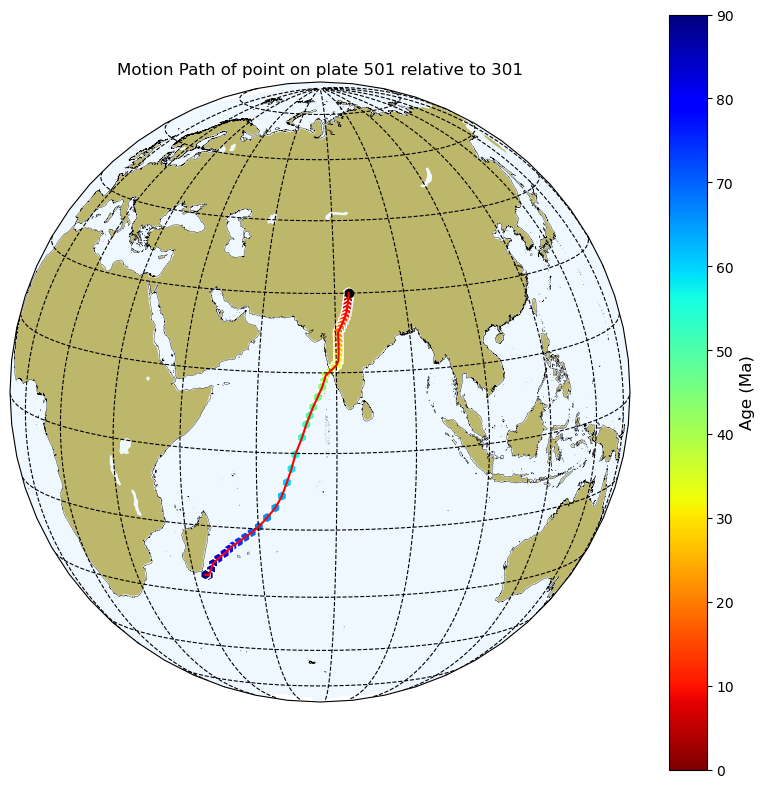

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import numpy as np
%matplotlib inline


# get the reconstructed plate geometry coordinates into numpy arrays
for reconstructed_motion_path in reconstructed_motion_paths:
    trail = reconstructed_motion_path.get_motion_path().to_lat_lon_array()

## Plotting - note that we use the median of the motion path coordinates as the map center
fig = plt.figure(figsize=(10,10), dpi=100)
ax_map = fig.add_subplot(111, projection=ccrs.Orthographic(central_longitude=np.median(trail[:,1]), 
                                                           central_latitude=np.median(trail[:,0])))

ax_map.coastlines(resolution='10m', color='black', linewidth=0.25)
ax_map.add_feature(cfeature.LAND, color = 'darkkhaki', edgecolor='black')
ax_map.add_feature(cfeature.OCEAN, color='aliceblue')
ax_map.add_feature(cfeature.LAKES, color='aliceblue', edgecolor='black')

# Gives meridians and parallels
ax_map.gridlines(color='black',linestyle='--', xlocs=np.arange(0,360,15), ylocs=np.arange(-90,90,15))


#Plot the movement of point on the plate.
x, y = np.flipud(trail[:,1]), np.flipud(trail[:,0])
ax_map.plot(x[0],y[0],'ko', transform=ccrs.PlateCarree())
ax_map.plot(x,y,'r', transform=ccrs.PlateCarree())
l1=ax_map.scatter(x, y, 60, c=times, marker='h',
                          cmap=plt.cm.jet_r, edgecolor='w', transform=ccrs.PlateCarree())
ax_map.set_title('Motion Path of point on plate %d relative to %d' % (MovingPlate,RelativePlate))


# Set a colourbar to visualise the passage of time (Ma)
fig.colorbar(l1, ax=ax_map).set_label('Age (Ma)',fontsize=12)

# Show global projection and plot
ax_map.set_global()
plt.show()

#### Quantifying rate of motion through time

Using the sequence of lat/lon cooordinates in the seedpoint array, we can calculate arrays of distance between consecutive points, and also velocity. In this example, the calculation is done using pygplates functions to get the arc length of individual segments within a line feature. By default distances are produced in units of a normalised sphere, so we multiple by an Earth radius embedded in pygplates.

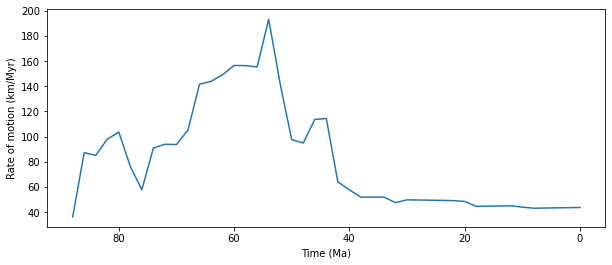

In [5]:
# Iterate over each segment in the reconstructed motion path, get the distance travelled by the moving
# plate relative to the fixed plate in each time step
Dist = []
for reconstructed_motion_path in reconstructed_motion_paths:
    for segment in reconstructed_motion_path.get_motion_path().get_segments():
        Dist.append(segment.get_arc_length()*pygplates.Earth.mean_radius_in_kms)

# Get rate of motion as distance per Myr
Rate = np.asarray(Dist)/TimeStep

# Note that the motion path coordinates come out starting with the oldest time and working forwards
# So, to match our 'times' array, we flip the order
Rate = np.flipud(Rate)

fig = plt.figure(figsize=(10,4))
plt.plot(times[:-1],Rate)
plt.xlabel('Time (Ma)')
plt.ylabel('Rate of motion (km/Myr)')
plt.gca().invert_xaxis()
plt.show()


To create a 'step plot' visualisation, some array manipulation is required to get time and rate arrays that contain values at the beginning and end of each 2 Myr time step

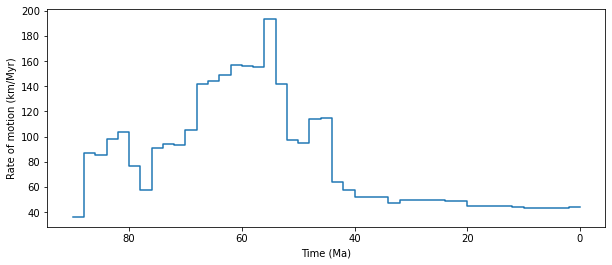

In [6]:
StepRate = np.zeros(len(Rate)*2)
StepRate[::2] = Rate
StepRate[1::2] = Rate

StepTime = np.zeros(len(Rate)*2)
StepTime[::2] = times[:-1]
StepTime[1::2] = times[1:]

fig = plt.figure(figsize=(10,4))
plt.plot(StepTime,StepRate)
plt.xlabel('Time (Ma)')
plt.ylabel('Rate of motion (km/Myr)')
plt.gca().invert_xaxis()
plt.show()


### 2 Changing Paleolatitude with time

This example is very similar to the one above - the main difference being that the motion is calculated for a single plate relative to the deep Earth using the 'absolute' reference frame embedded in the Seton et al (2012) rotation model. The construction of the motion path feature differs only in the plate id for the fixed (or relative) plate, which is 0 in this case.

In [7]:
SeedPoint = (10,15)
MovingPlate = 701
RelativePlate = 0
times = np.arange(0,130,10.)

# Create a motion path feature
digitisation_time = 0
seed_points_at_digitisation_time = pygplates.MultiPointOnSphere([SeedPoint]) 
motion_path_feature = pygplates.Feature.create_motion_path(
        seed_points_at_digitisation_time,
        times,
        valid_time=(200, 0),
        relative_plate=RelativePlate,
        reconstruction_plate_id = MovingPlate)

# Create the shape of the motion path
reconstruction_time = 0
reconstructed_motion_paths = []
pygplates.reconstruct(
        motion_path_feature, rotation_model, reconstructed_motion_paths, reconstruction_time,
        reconstruct_type=pygplates.ReconstructType.motion_path)

# get the reconstructed coordinates into numpy arrays
for reconstructed_motion_path in reconstructed_motion_paths:
    trail = reconstructed_motion_path.get_motion_path().to_lat_lon_array()
 

We can plot the latitude coordinate of each point along the motion path to illustrate how far any given point has drifted north or south over time (based on a given reference frame - there are a number of competing models). The O'Neill et al (2005) reference frame predicts that Africa has drifted around 20 degrees north in the last 120 Ma.

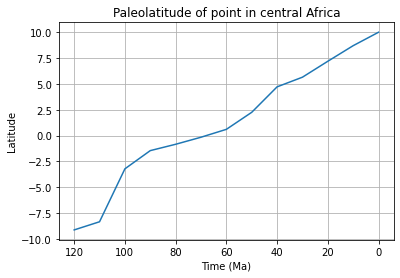

In [8]:
plt.plot(times,np.flipud(trail[:,0]))
plt.title('Paleolatitude of point in central Africa')
plt.xlabel('Time (Ma)')
plt.ylabel('Latitude')
plt.gca().grid()
plt.gca().invert_xaxis()
plt.show()


### 3. A hotspot trail example:
In this use case, we want to visualise relative motion of the African plate with respect to the Tristan 'hotspot'. Within a reconstruction model, this relative motion is defined by the absolute reference frame describing how Africa has moved relative to the underlying mantle, such as the O'Neill et al (2005) study (used in the GPlates default reconstruction model. In this example we use the simple case where the hotspot is assumed to be approximately 'fixed' for the last 130 Ma, although estimates of how the hotspot may have moved during this period have been proposed.

In [9]:
# Define new parameters for the feature that will map the hotspot trail
SeedPoint = (-39,-11)
RelativePlate = 701
times = np.arange(0,131,5.)

# Create a motion path feature
digitisation_time = 0
seed_points_at_digitisation_time = pygplates.MultiPointOnSphere([SeedPoint]) # Two lat/lon seed points
motion_path_feature = pygplates.Feature.create_motion_path(
        seed_points_at_digitisation_time,
        times,
        valid_time=(200, 0),
        relative_plate=RelativePlate,
        reconstruction_plate_id=1)

# Create the shape of the motion path
reconstruction_time = 0
reconstructed_motion_paths = []
pygplates.reconstruct(
        motion_path_feature, rotation_model, reconstructed_motion_paths, reconstruction_time,
        reconstruct_type=pygplates.ReconstructType.motion_path)

# get the reconstructed coordinates into numpy arrays
for reconstructed_motion_path in reconstructed_motion_paths:
    trail = reconstructed_motion_path.get_motion_path().to_lat_lon_array()
 

### Plot the predicted hotspot trail


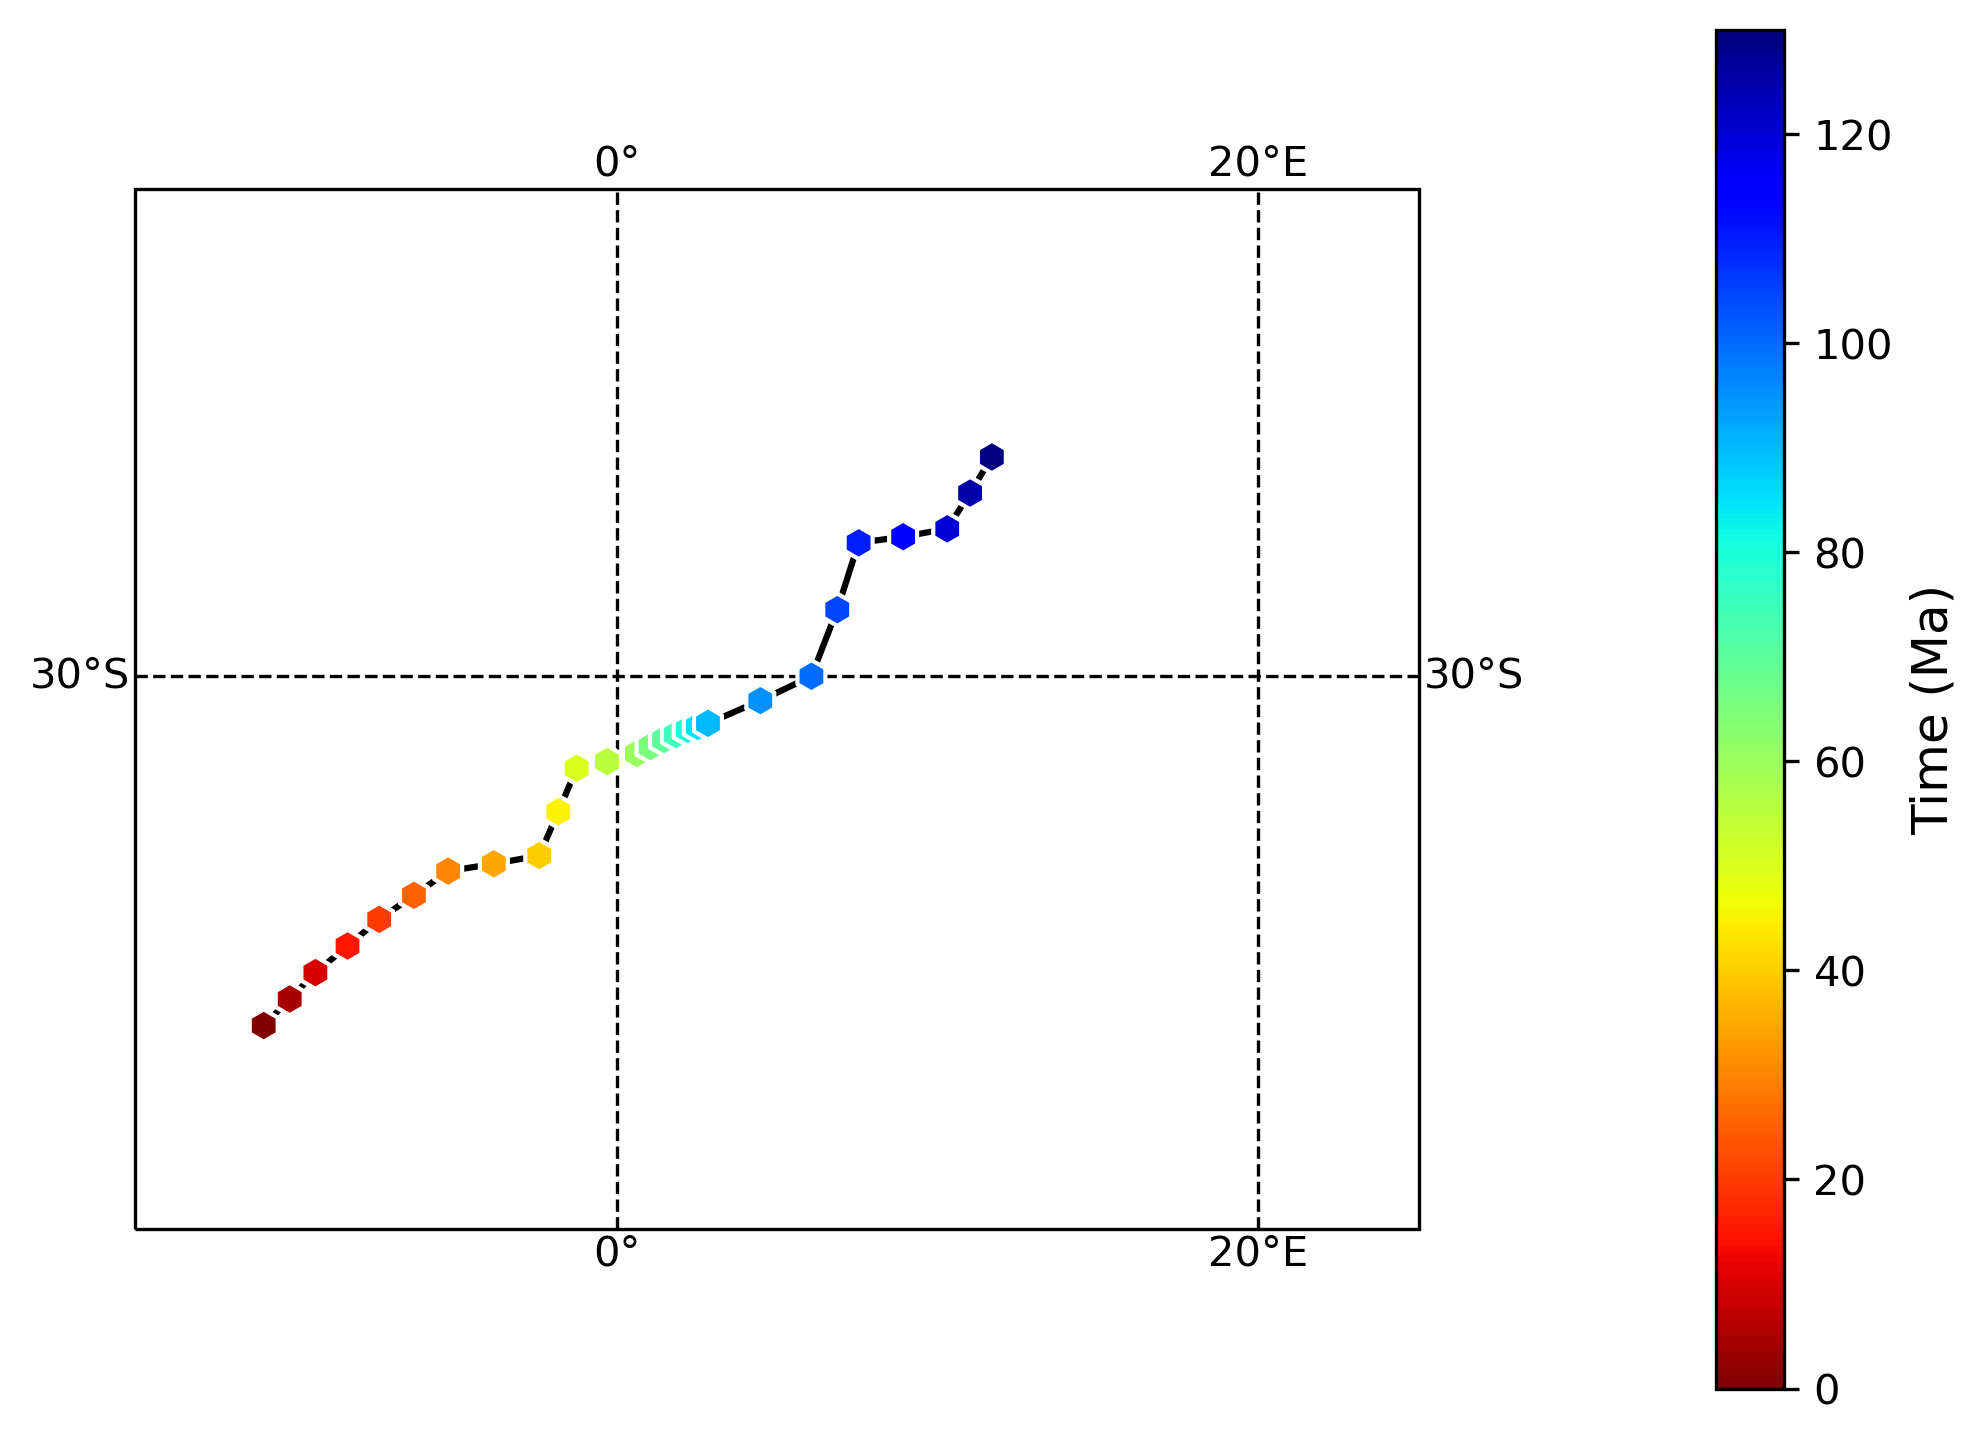

In [10]:
# Set up the figure
fig = plt.figure(figsize=(8,6), dpi=300)
ax_map = fig.add_subplot(111, projection=ccrs.Mercator())
ax_map.set_extent([-15, 25, -42, -16])
ax_map.gridlines(color='black',linestyle='--', xlocs=np.arange(0,360,20), ylocs=np.arange(-90,90,20), 
                 draw_labels=True)
ax_map.xlabels_top = False
ax_map.xlabels_right = False

# Plot hotspot trail coordinates
x,y = np.flipud(trail[:,1]), np.flipud(trail[:,0])
ax_map.plot(x, y, 'k', transform=ccrs.PlateCarree(), zorder=2)
l1=ax_map.scatter(x, y, 60, c=times, marker='h',
                          cmap=plt.cm.jet_r, edgecolor='w', transform=ccrs.PlateCarree(), zorder=3)

# Set a colourbar to visualise the passage of time (Ma)
fig.colorbar(l1, ax=ax_map, pad=0.16).set_label('Time (Ma)',fontsize=12)

# Show plot
plt.show()